# 主題：政治新聞資料分析
- 組員：王冠人、萬俊彥、廖品琪
- 時間：2019/01/29

## 研究目標
考量臺灣社會政治冷感的現狀，提供一個較為客觀的資料統整，藉由日常生活中的事件觀察政治人物的網路聲量變化，作為一種參與政治的方式。

## 研究方法
1. 爬蟲搜尋網路新聞
2. 進行資料清理及資料分析
4. 視覺化呈現研究結果

## 研究內容及結果

# Part I 爬蟲

- [新頭殼新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/new_talk_crawler.ipynb)
- [自由時報新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/liberty_times_crawler.ipynb)

#  Part II 資料清洗及分析

In [1]:
import jieba

In [2]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *

font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### 載入新聞資料

In [4]:
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1]
contents = [news['content'] for news in data]

### 使用 coshow 找出新詞 -> 自定義辭典

In [5]:
get_coshow(contents[:1000])[:10]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.674 seconds.
Prefix dict has been built succesfully.


[('68', 1001),
 ('民進黨', 617),
 ('對於', 475),
 ('蔡英文', 471),
 ('柯文哲', 442),
 ('台北市長', 356),
 ('長參選人', 316),
 ('沒有', 288),
 ('今（', 261),
 ('）日', 258)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [6]:
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

Building prefix dict from /home/billy/Desktop/Political-News-Analysis/jieba_data/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u21eaf96b8f25ff29b8b26fad282a744b.cache
Loading model cost 1.397 seconds.
Prefix dict has been built succesfully.


In [7]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

In [8]:
get_coshow(contents[:1000])[:10]

[('68', 1001),
 ('今（', 390),
 ('）日', 327),
 ('他的', 254),
 ('為了', 252),
 ('都是', 250),
 ('也是', 216),
 ('台灣的', 203),
 ('的人', 196),
 ('的是', 187)]

In [9]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1380),
 ('國民黨', 783),
 ('侯友宜', 716),
 ('柯文哲', 691),
 ('民進黨', 681),
 ('指出', 600),
 ('中國', 561),
 ('媒體', 541),
 ('選舉', 521),
 ('市府', 501),
 ('希望', 494),
 ('公司', 487),
 ('一個', 469),
 ('美國', 464),
 ('政府', 448),
 ('未來', 413),
 ('提供', 412),
 ('蘇貞昌', 388),
 ('針對', 349),
 ('國家', 337)]

In [10]:
cutted_dict = get_cutted_dict(contents)

In [11]:
# 可能人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)
possible_name[:10]

[('民進黨', 8922),
 ('國民黨', 8420),
 ('柯文哲', 8153),
 ('韓國瑜', 6590),
 ('陳其邁', 4683),
 ('蔡英文', 3738),
 ('蘇貞昌', 3280),
 ('姚文智', 2973),
 ('候選人', 2946),
 ('侯友宜', 2665)]

In [12]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200, 4)
possible_events[:10]

[('台北市長柯文哲', 1590),
 ('總統蔡英文', 1356),
 ('時代力量', 1135),
 ('九二共識', 1022),
 ('行政院長賴清德', 1003),
 ('中華民國', 852),
 ('競選總部', 779),
 ('蔡英文總統', 762),
 ('競選辦公室', 720),
 ('兩岸關係', 708)]

### 載入人名、事件

In [13]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [14]:
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

47782


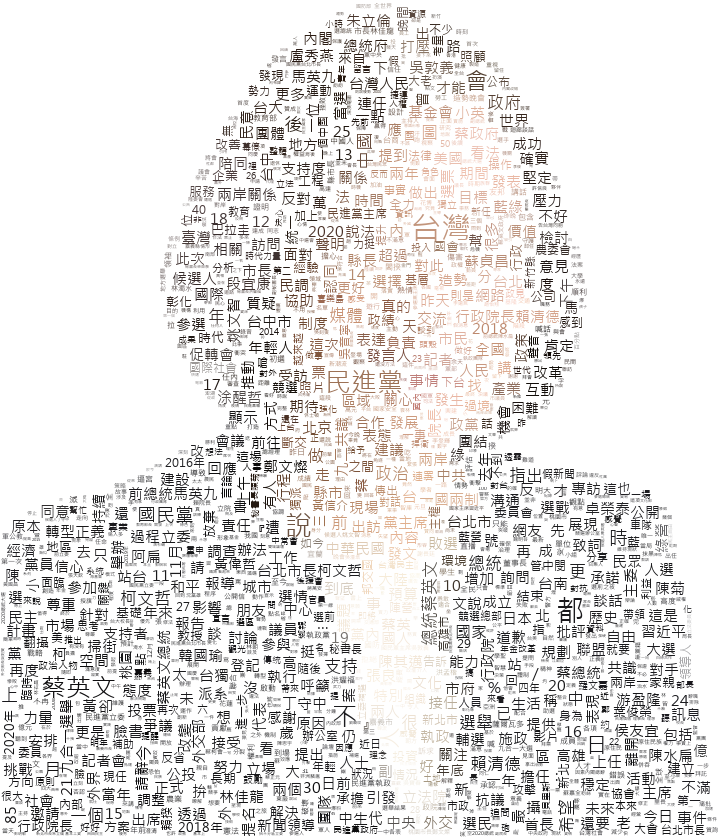

In [15]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [16]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5039), ('民進黨', 3893), ('蔡英文', 3738), ('中國', 2136), ('國民黨', 2021)]

42597


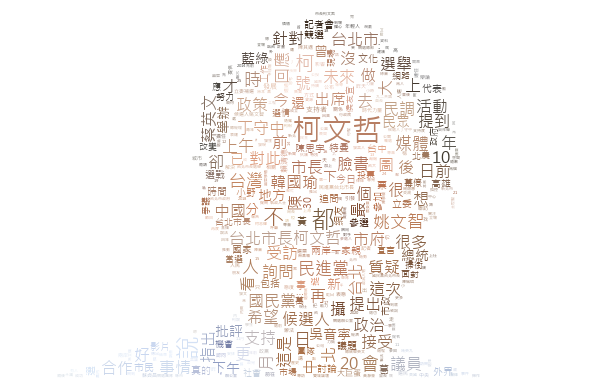

In [17]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [18]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 5)

[('柯文哲', 8153), ('媒體', 2356), ('姚文智', 2120), ('台灣', 2117), ('民進黨', 2107)]

### get date

In [19]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
aall_date = [date[5:] for date in all_date][::-1]
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [20]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-1):
#     print(date_index[i+1])
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [21]:
# 每日詞頻
tf_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [22]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [23]:
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)

df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

### 畫圖

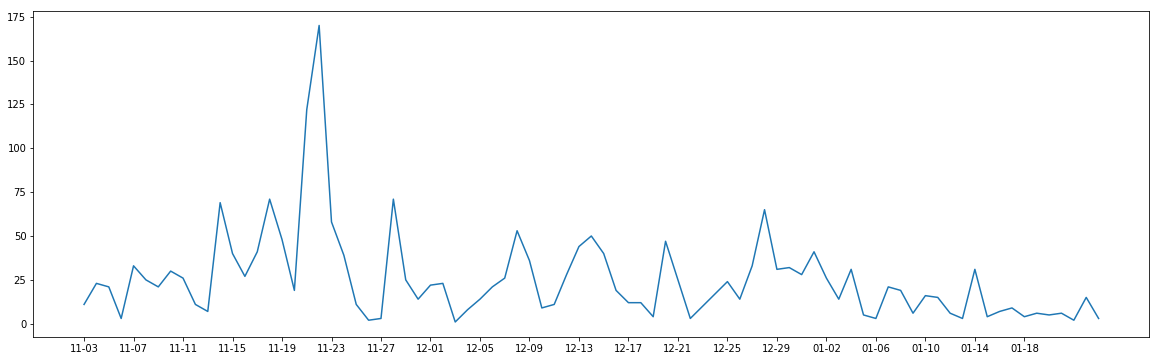

In [24]:
# word times
plt.figure(figsize=(20,6))
plt.plot(aall_date[147:], df.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.show()

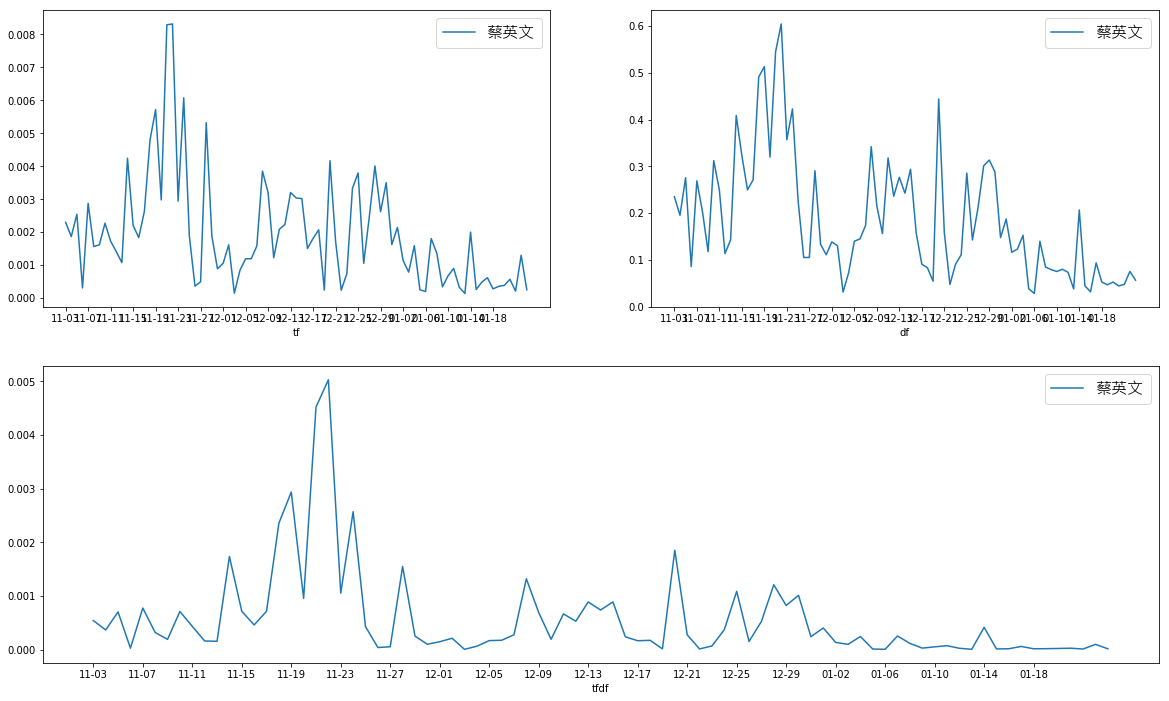

In [25]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='../msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(212)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

In [26]:
def plot_tfdf_of_word(word, df_tf, df_occur, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df_tf.columns.get_loc(date_from)
    to_index = df_tf.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='../msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])

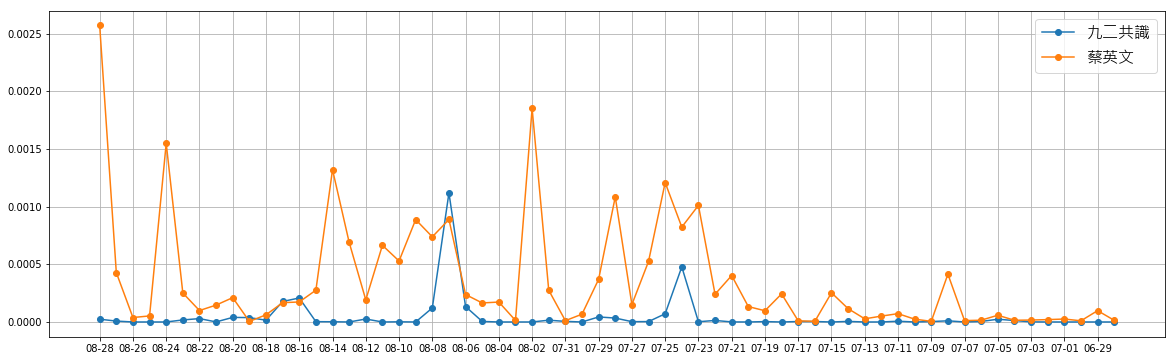

In [27]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('九二共識', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

### 大事件被討論的時間區段與聲量

In [28]:
def get_high_tfdf_date(word, df_tf, df_occur):
    tfdf = get_tfdf(word, df_tf, df_occur)
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf]
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    return tfdf_date

def draw_event(event, i, df_tf, df_occur):
    event_date = get_high_tfdf_date(event, df_tf, df_occur)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])

In [29]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e, df_tf, df_occur) for e in events}
event_high_tfdf_dict['九二共識']

{'2018-11-27': 0.00047779497618490654,
 '2018-12-11': 0.0011198556630478739,
 '2019-01-02': 0.000594875366356171,
 '2019-01-03': 0.0009785214540828804,
 '2019-01-04': 0.0010009700759377913,
 '2019-01-05': 0.0021587700031377474,
 '2019-01-06': 0.00248043037077602,
 '2019-01-07': 0.0021426805483064585,
 '2019-01-08': 0.0007637399759128163,
 '2019-01-09': 0.0009532888465204956,
 '2019-01-10': 0.000895789787996417,
 '2019-01-17': 0.0005606260193200352}

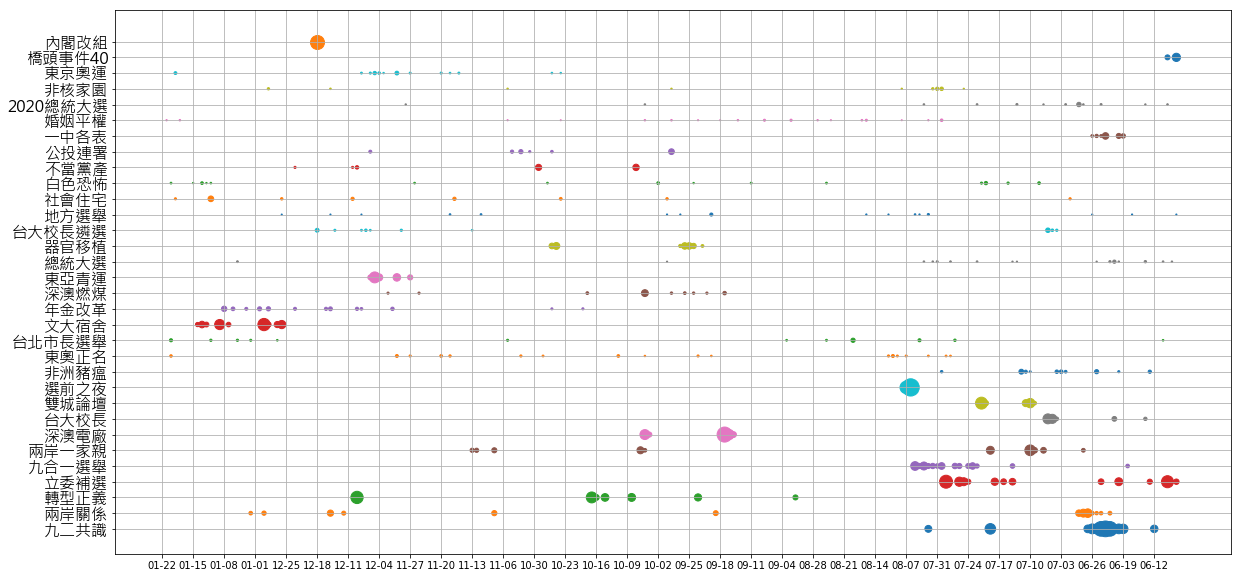

In [30]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i, df_tf, df_occur)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [31]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
# with open('../data/event_people_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(event_people_dict, j)

In [32]:
pd.DataFrame(event_people_dict).T.head(3)

,丁允恭,丁守中,任美鈴,何孟樺,何志偉,何瑞英,余登發,侯友宜,劉世芳,劉奕霆,...,高思博,高育仁,魏明谷,黃信介,黃偉哲,黃國昌,黃士修,黃敏惠,黃瀞瑩,黃韋鈞
九二共識,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
兩岸關係,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
轉型正義,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN


In [33]:
people_tfdf_dict = {name: list(get_tfdf(name, df_tf, df_occur)) for name in names}

In [34]:
pd.DataFrame(people_tfdf_dict, index=aall_date).T.head(4)

,01-22,01-21,01-20,01-19,01-18,01-17,01-16,01-15,01-14,01-13,...,06-16,06-15,06-14,06-13,06-12,06-11,06-10,06-09,06-08,06-07
柯文哲,0.000135,0.000220,0.000546,0.000000,0.000286,0.000006,0.000234,0.000732,0.000221,0.000109,...,0.000117,0.000233,0.000123,0.000265,0.000259,0.001432,0.001921,0.002752,0.002131,0.001046
韓國瑜,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000706,0.000000,0.000000,...,0.000631,0.000056,0.000043,0.000002,0.001641,0.000389,0.002984,0.006289,0.000092,0.000197
陳其邁,0.000000,0.000118,0.000273,0.000047,0.000000,0.000000,0.000015,0.000029,0.000045,0.000000,...,0.000105,0.000196,0.000078,0.000060,0.000020,0.000017,0.000000,0.000176,0.000000,0.000000
蔡英文,0.000135,0.000152,0.000257,0.000070,0.000034,0.000146,0.000089,0.000118,0.000136,0.000000,...,0.000161,0.000432,0.000711,0.000191,0.000319,0.000775,0.000027,0.000703,0.000366,0.000542


# Part III 視覺化呈現研究結果

In [35]:
# import packages
import math
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime, timedelta
import json

In [36]:
import plotly 
plotly.tools.set_credentials_file(username='bobsonlin', api_key='qNLLW1jzxa0blLdyarUw')

#### Section I 政治事件網路聲量分析

In [37]:
def get_scatter_trace(points_x, points_y, points_size=10, trace_name='', line=False):
    if line:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'lines',
            hoverinfo = 'x+y',
            name
            = trace_name,
            text = points_size,
            yaxis = 'y2',
            line = {
                "color": 'rgba(255, 166, 87, 0.4)'
            }
        )
    else:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'markers' if not line else 'lines',
            marker = {
                'size': points_size
            },
            hoverinfo = 'text+name',
            name = trace_name,
            text = points_size
        )

In [38]:
events = json.loads(open('../data/event_tfdf_dict.json').read())

In [39]:
def sectionI_plot(ori_data, title=''):
    
    # data
    fig_data = []
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for date, tfdf_val in ori_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(ori_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    display(py.iplot(fig, filename='bubble-event'))

In [40]:
sectionI_plot(events)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bobsonlin/0 or inside your plot.ly account where it is named 'bubble-event'


#### Section II 事件相關人聲量分析

In [41]:
event_people_relation = json.loads(open('../data/event_people_dict.json').read())

In [42]:
def sectionII_plot(event_name, ori_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # data
    fig_data = []
    x, y, size = [], [], []
    for date, tfdf_val in events[event_name].items():
        x.append(datetime.strptime(date, "%Y-%m-%d"))
        y.append(len(ori_data) + 1)
        size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
    fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=event_name))
        
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for day_index, tfdf_val in enumerate(ori_data[name]):
            if tfdf_val != 0:
                x.append(start_date + timedelta(days=day_index))
                y.append(len(ori_data) - index)
                size.append(max(math.log(round(tfdf_val, 2))*10,0)) ## constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='People'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)

    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='event-people'))


In [43]:
event_selector = widgets.Dropdown(
    options=list(events.keys()),
    description='政治事件：'
)
display(event_selector)

def event_change(change):
    top_10_related_people = dict(sorted(event_people_relation[change['new']].items(), key=lambda x: sum(x[1]), reverse=True)[:10])
    sectionII_plot(change['new'], top_10_related_people, event_selector, title=change['new'])

event_change({'new': list(events.keys())[0]})
    
event_selector.observe(event_change, names='value')

Dropdown(description='政治事件：', options=('九二共識', '兩岸關係', '轉型正義', '立委補選', '九合一選舉', '兩岸一家親', '深澳電廠', '台大校長', '雙城論壇…

#### Section III 人物聲量與事件疊圖分析

In [44]:
people = json.loads(open('../data/people_tfdf_dict.json').read())

In [45]:
def sectionIII_plot(people_data, events_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    fig_data = []
    
    # people data
    x, y = [], []
    for day_index, value in enumerate(people_data['tfdf']):
        x.append(start_date + timedelta(days=day_index))
        y.append(value)
    fig_data.append(get_scatter_trace(x, y, line=True))
    
    # event data
    for index, name in enumerate(events_data):
        x, y, size = [], [], []
        for date, tfdf_val in events_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(events_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        ),
        yaxis2=dict(
            title='People Reputation',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    
    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='person-events'))

In [46]:
people_selector = widgets.Dropdown(
    options=list(people.keys()),
    description='政治人物：'
)
display(people_selector)

def people_change(change):
    sectionIII_plot({
        'name': change['new'],
        'tfdf': people[change['new']]
    }, events, people_selector, title='人物與事件聲量圖({})'.format(change['new']))

people_change({'new': list(people.keys())[0]})
    
people_selector.observe(people_change, names='value')


Dropdown(description='政治人物：', options=('柯文哲', '韓國瑜', '陳其邁', '蔡英文', '蘇貞昌', '姚文智', '侯友宜', '丁守中', '賴清德', '馬英九', '…

### Visualization
[Section I 政治事件網路聲量分析](https://plot.ly/~a136489/67)

[Section II 事件相關人聲量分析](https://plot.ly/~a136489/69/#/)

[Section III 人物聲量與事件疊圖分析](https://plot.ly/~a136489/71)
